## Simplest 1DX1D GP:

2024-11-25 09:38:21.244847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 09:38:21.340397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-25 09:38:21.340418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-25 09:38:21.365873: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 09:38:21.807399: W tensorflow/stream_executor/platform/de

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

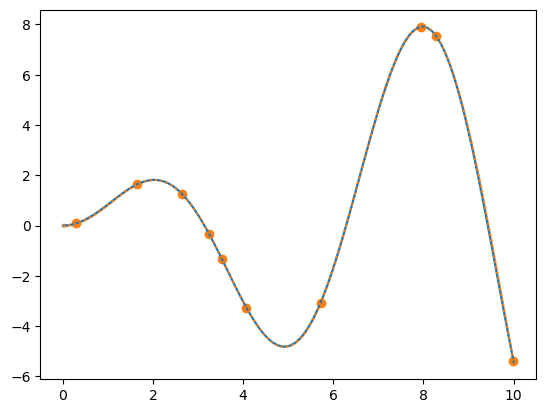

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import gpflow
from gpflow.models import GPR
from gpflow.kernels import SquaredExponential
from gpflow.optimizers import Scipy
from gpflow.utilities import print_summary
import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error

def get_truth(X):

    return X * np.sin(X)

def build_model(X_train, Y_train):
    """
    """
    kernel = SquaredExponential()
    kernel.lengthscales.trainable = True
    kernel.variance.trainable = True
    model = GPR(data=(X_train, Y_train), kernel=kernel)
    print(print_summary(model))
    return model
    
def train_model(model):
    """
    """
    opt = Scipy()
    opt_logs = opt.minimize(model.training_loss, variables=model.trainable_variables, options=dict(maxiter=1e11))
    return model


fig, ax = plt.subplots()

n_samples = 10

X_train = np.random.uniform(0, 10, (n_samples, 1))
Y_train = get_truth(X_train)

model = build_model(X_train, Y_train)
model = train_model(model)

X_test = np.linspace(0, 10, 100)[:, None]

truth = get_truth(X_test)
ax.plot(X_test, truth)

mean, var = model.predict_y(X_test)

ax.scatter(X_train, Y_train, color='C1')

ax.plot(X_test, mean, color='C1', ls='dotted')
ax.fill_between(X_test.squeeze(), (mean-np.sqrt(var)).numpy().squeeze(), (mean+np.sqrt(var)).numpy().squeeze(), alpha=0.5, color='C1')




print(f'lenghtscales: {model.kernel.lengthscales.numpy()}, variance: {model.kernel.variance.numpy()}')
    

## 2DX1D:

(120, 2) (120, 1)
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1. 1.] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.0     │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧══════════

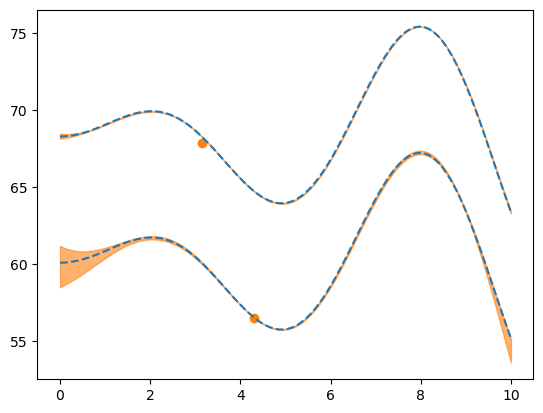

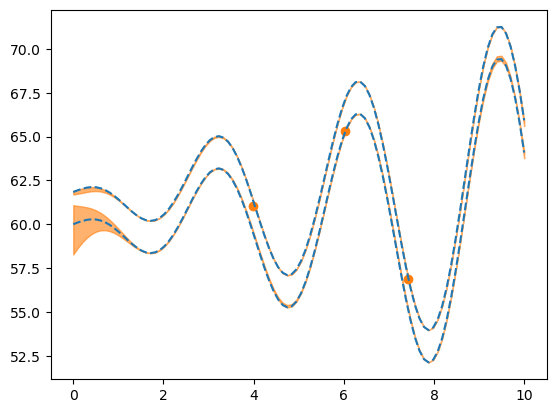

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import gpflow
from gpflow.models import GPR
from gpflow.kernels import SquaredExponential
from gpflow.optimizers import Scipy
from gpflow.utilities import print_summary
import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

def get_truth(X):

    return 60 + 0.9 * X[:,0] * np.sin(X[:,0]) + X[:,1] * np.cos(2*X[:,1])

def normalize(Y):
    """
    """
    medind = np.argsort(np.mean(Y, axis=1))[np.shape(Y)[0]//2]
    mean_func = Y[medind,:]

    return mean_func

def build_model(X_train, Y_train):
    """
    """
    mean_func = normalize(Y_train)
    dtype = mean_func.dtype
    class MeanFunction(gpflow.mean_functions.MeanFunction):
        def __call__(self, X):
            return tf.convert_to_tensor(mean_func, dtype=dtype)
    lengthscales = tf.convert_to_tensor([1.0] * ndim_input, dtype=X_train.dtype)
    kernel = SquaredExponential(lengthscales=lengthscales)
    kernel.lengthscales.trainable = True
    kernel.variance.trainable = True
    print(X_train.shape, Y_train.shape)
    model = GPR(data=(X_train, Y_train), kernel=kernel, mean_function=MeanFunction())
    print(print_summary(model))
    return model
    
def train_model(model):
    """
    """
    opt = Scipy()
    opt_logs = opt.minimize(model.training_loss, variables=model.trainable_variables, options=dict(maxiter=1e11))
    return model




n_samples = 120
ndim_input = 2

X_train = np.random.uniform(0, 10, (n_samples, ndim_input))
Y_train = get_truth(X_train).reshape(-1, 1)

model = build_model(X_train, Y_train)
model = train_model(model)


a = np.linspace(0, 10, 100)

for s in range(2):
    fig, ax = plt.subplots()
    for x in [0.1, 9.2]:
        if s==1:
            X_test = np.vstack(([x]*a.size, a.flatten())).T
        else:
            X_test = np.vstack((a.flatten(), [x]*a.size)).T
        
        ax.plot(X_test[:,s], get_truth(X_test), color='C0', ls='--')
        ind = np.where((X_train[:,(s+1)%2] >= x-0.05)*(X_train[:,(s+1)%2] <= x+0.05))[0]
        ax.scatter(X_train[ind,s], Y_train[ind], color='C1')

        mean, var = model.predict_y(X_test)

        ax.fill_between(X_test[:,s], (mean-np.sqrt(var)).numpy().squeeze(), (mean+np.sqrt(var)).numpy().squeeze(), alpha=0.6, color='C1')




print(f'lenghtscales: {model.kernel.lengthscales.numpy()}, variance: {model.kernel.variance.numpy()}')
    

## 2DX2D:

mean_func: [64.29321818 31.22450782 32.3512486 ]
(500, 2) (500, 3)
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1. 1.] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.0     │
╘═════════════════════════╧══

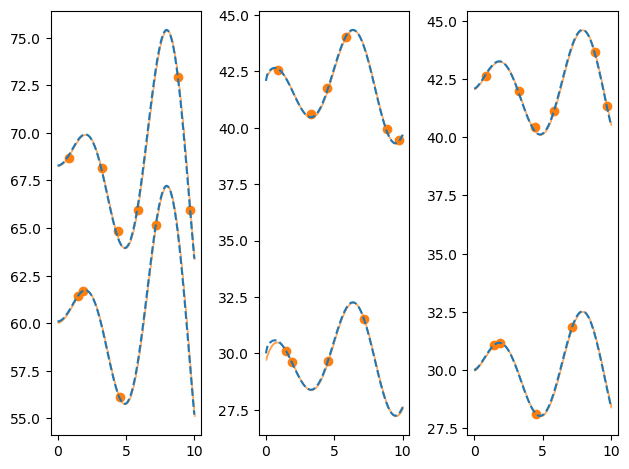

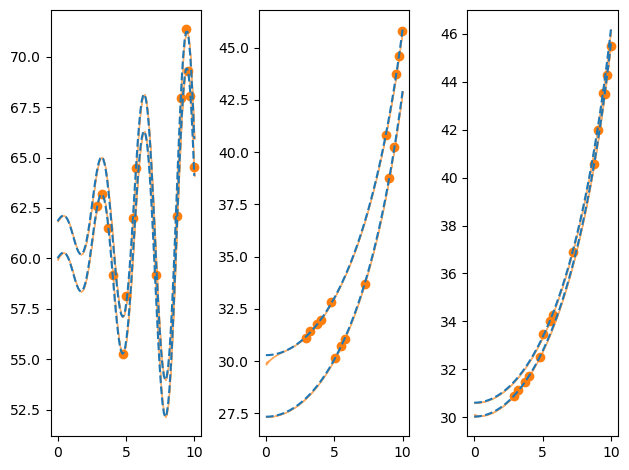

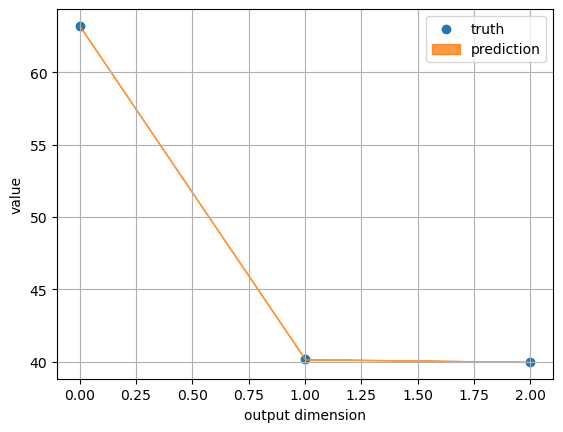

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import gpflow
from gpflow.models import GPR
from gpflow.kernels import SquaredExponential
from gpflow.optimizers import Scipy
from gpflow.utilities import print_summary
import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

def get_truth(X):
    y = np.zeros((X.shape[0], 3))
    y[:,0] = 60 + 0.9 * X[:,0] * np.sin(X[:,0]) + X[:,1] * np.cos(2*X[:,1])
    y[:,1] = 30 + 0.9 * X[:,0]**0.5 * np.cos(X[:,0])  + X[:,1] * np.tan(0.1*X[:,1])
    y[:,2] = 10 + 0.7 * X[:,0]**0.8 * np.sin(X[:,0])  + 2*X[:,1] * np.tan(0.1*X[:,1])
    return y

def normalize(X,Y):
    """
    """
    X_min, X_max = tf.reduce_min(X, axis=0), tf.reduce_max(X, axis=0)

    X = (X - X_min) / (X_max - X_min)
    medind = np.argsort(np.mean(Y, axis=1))[np.shape(Y)[0]//2]
    mean_func = Y[medind,:]
    print(f'mean_func: {mean_func}')

    return mean_func, X_min, X_max

def build_model(X_train, Y_train):
    """
    """
    mean_func, xmin, Xmax = normalize(X_train, Y_train)
    X_train_norm = (X_train - xmin) / (Xmax - xmin)
    dtype = mean_func.dtype
    class MeanFunction(gpflow.mean_functions.MeanFunction):
        def __call__(self, X):
            return tf.convert_to_tensor(mean_func, dtype=dtype)
    lengthscales = tf.convert_to_tensor([1.0] * ndim_input, dtype=X_train.dtype)
    kernel = SquaredExponential(lengthscales=lengthscales)
    kernel.lengthscales.trainable = True
    kernel.variance.trainable = True
    print(X_train.shape, Y_train.shape)
    model = GPR(data=(X_train_norm, Y_train), kernel=kernel, mean_function=MeanFunction())
    print(print_summary(model))
    return model, xmin, Xmax
    
def train_model(model):
    """
    """
    opt = Scipy()
    opt_logs = opt.minimize(model.training_loss, variables=model.trainable_variables, options=dict(maxiter=1e11))
    return model


np.random.seed=10

n_samples = 500
ndim_input = 2
ndim_output = 3

X_train = np.random.uniform(0, 10, (n_samples, ndim_input))
Y_train = get_truth(X_train)


model, X_min, X_max = build_model(X_train, Y_train)
model = train_model(model)


a = np.linspace(0, 10, 100)

for s in range(2):
    fig, ax = plt.subplots(1,3)
    for x in [0.1, 9.2]:
        if s==1:
            X_test = np.vstack(([x]*a.size, a.flatten())).T
        else:
            X_test = np.vstack((a.flatten(), [x]*a.size)).T
        X_test_norm = (X_test - X_min) / (X_max - X_min)
        for dout in range(ndim_output):     
            ax[dout].plot(X_test[:,s], get_truth(X_test)[:,dout], color='C0', ls='--')
            ind = np.where((X_train[:,(s+1)%2] >= x-0.05)*(X_train[:,(s+1)%2] <= x+0.05))[0]
            ax[dout].scatter(X_train[ind,s], Y_train[ind, dout], color='C1')

            mean, var = model.predict_y(X_test_norm)

            ax[dout].fill_between(X_test[:,s], (mean[:, dout]-np.sqrt(var[:,dout])).numpy().squeeze(), (mean[:, dout]+np.sqrt(var[:, dout])).numpy().squeeze(), alpha=0.6, color='C1')

    fig.tight_layout()


print(f'lenghtscales: {model.kernel.lengthscales.numpy()}, variance: {model.kernel.variance.numpy()}')

## Plots similar to Corr
X_test = np.array([4, 9])[None, :]
X_test_norm = (X_test - X_min) / (X_max - X_min)
means, vars = model.predict_y(X_test_norm)

means = means.numpy().squeeze()
vars = vars.numpy().squeeze()

fig, ax = plt.subplots()
truth = get_truth(X_test)
print(f'mean: {means}, truth: {truth}')
ax.scatter(np.arange(truth.size), truth, color='C0', marker='o', label='truth')
ax.fill_between(np.arange(means.size), (means-np.sqrt(vars)).squeeze(), (means+np.sqrt(vars)).squeeze(), alpha=0.8, color='C1', label='prediction')
ax.legend()
ax.set_xlabel('output dimension')
ax.set_ylabel('value')
ax.grid()

    

## 2DX3D: 1 gp for each Y bin

mean_func: [65.0293813  30.17185862 16.59538481]
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1. 1.] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.0     │
╘═════════════════════════╧═══════════╧════════

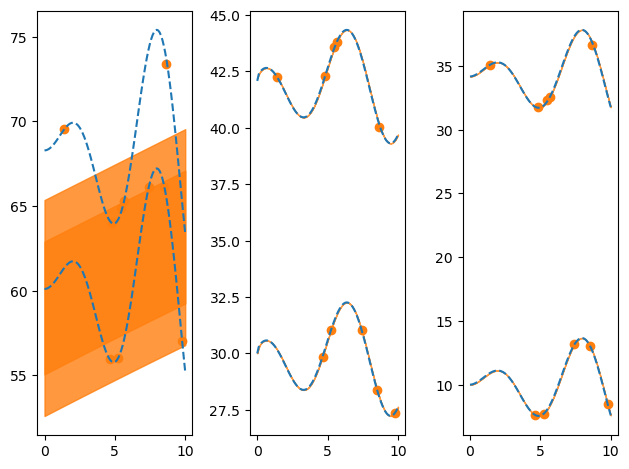

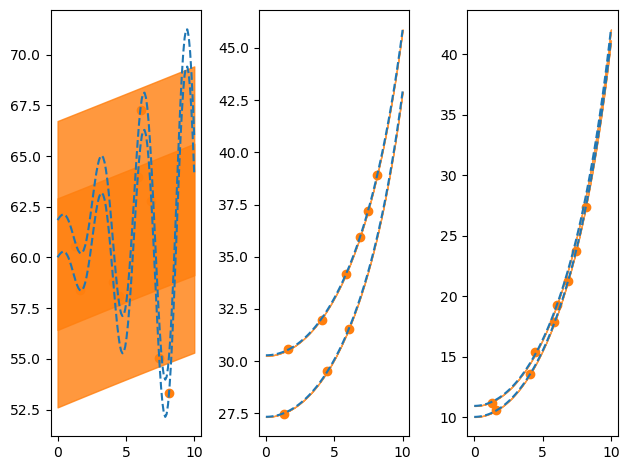

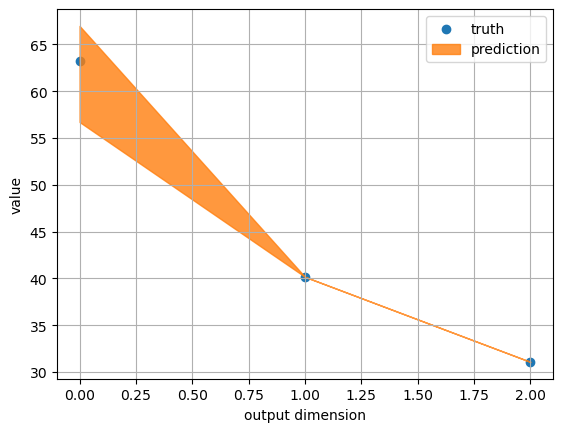

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import gpflow
from gpflow.models import GPR
from gpflow.kernels import SquaredExponential
from gpflow.optimizers import Scipy
from gpflow.utilities import print_summary
import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

def get_truth(X):
    y = np.zeros((X.shape[0], 3))
    y[:,0] = 60 + 0.9 * X[:,0] * np.sin(X[:,0]) + X[:,1] * np.cos(2*X[:,1])
    y[:,1] = 30 + 0.9 * X[:,0]**0.5 * np.cos(X[:,0])  + X[:,1] * np.tan(0.1*X[:,1])
    y[:,2] = 10 + 0.7 * X[:,0]**0.8 * np.sin(X[:,0])  + 2*X[:,1] * np.tan(0.1*X[:,1])
    return y

def normalize(X,Y):
    """
    """
    X_min, X_max = tf.reduce_min(X, axis=0), tf.reduce_max(X, axis=0)

    X = (X - X_min) / (X_max - X_min)
    medind = np.argsort(np.mean(Y, axis=1))[np.shape(Y)[0]//2]
    mean_func = Y[medind,:]
    print(f'mean_func: {mean_func}')

    return mean_func, X_min, X_max

def build_model(X_train, Y_train):
    """
    """
    models = []
    mean_func, Xmin, Xmax = normalize(X_train, Y_train)
    X_train_norm = (X_train - Xmin) / (Xmax - Xmin)
    dtype = mean_func.dtype
    for dout in range(Y_train.shape[1]):
        class MeanFunction(gpflow.mean_functions.MeanFunction):
            def __call__(self, X):
                return tf.convert_to_tensor(mean_func[dout], dtype=dtype)
        lengthscales = tf.convert_to_tensor([1.0] * ndim_input, dtype=X_train.dtype)
        kernel = SquaredExponential(lengthscales=lengthscales)
        kernel.lengthscales.trainable = True
        kernel.variance.trainable = True
        model = GPR(data=(X_train_norm, Y_train[:,dout][:,None]), kernel=kernel, mean_function=MeanFunction())
        print(print_summary(model))
        models.append(model)
    return models, Xmin, Xmax
    
def train_model(gp_bins):
    """
    """
    trained_gps = []
    for gp in gp_bins:
        opt = Scipy()
        opt_logs = opt.minimize(gp.training_loss, variables=gp.trainable_variables, options=dict(maxiter=1e11))
        trained_gps.append(gp)
    return trained_gps


n_samples = 500
ndim_input = 2
ndim_output = 3

X_train = np.random.uniform(0, 10, (n_samples, ndim_input))
Y_train = get_truth(X_train)


model_bins, X_min, X_max = build_model(X_train, Y_train)
model_bins = train_model(model_bins)


a = np.linspace(0, 10, 100)

for s in range(2):
    fig, ax = plt.subplots(1,3)
    for x in [0.1, 9.2]:
        if s==1:
            X_test = np.vstack(([x]*a.size, a.flatten())).T
        else:
            X_test = np.vstack((a.flatten(), [x]*a.size)).T
        X_test_norm = (X_test - X_min) / (X_max - X_min)
        for dout in range(ndim_output):     
            ax[dout].plot(X_test[:,s], get_truth(X_test)[:,dout], color='C0', ls='--')
            ind = np.where((X_train[:,(s+1)%2] >= x-0.05)*(X_train[:,(s+1)%2] <= x+0.05))[0]
            ax[dout].scatter(X_train[ind,s], Y_train[ind, dout], color='C1')

            mean, var = model_bins[dout].predict_y(X_test_norm)

            ax[dout].fill_between(X_test[:,s], (mean-np.sqrt(var)).numpy().squeeze(), (mean+np.sqrt(var)).numpy().squeeze(), alpha=0.8, color='C1')
            print(f'lenghtscales: {model_bins[dout].kernel.lengthscales.numpy()}, variance: {model_bins[dout].kernel.variance.numpy()}')
    fig.tight_layout()


## plots similar to Corr
X_test = np.array([4, 9])[None, :]
X_test_norm = (X_test - X_min) / (X_max - X_min)
means, vars = np.zeros((3,1)), np.zeros((3,1))
for dout in range(ndim_output):
    means[dout], vars[dout] = model_bins[dout].predict_y(X_test_norm)

fig, ax = plt.subplots()
truth = get_truth(X_test)
print(f'mean: {means}, truth: {truth}')
ax.scatter(np.arange(truth.size), truth, color='C0', marker='o', label='truth')
ax.fill_between(np.arange(means.size), (means-np.sqrt(vars)).squeeze(), (means+np.sqrt(vars)).squeeze(), alpha=0.8, color='C1', label='prediction')
ax.legend()
ax.set_xlabel('output dimension')
ax.set_ylabel('value')
ax.grid()


    

1 GP for all Y bins does much better job for all bins, but moddeling each Y-bin seperately does better for some bins and very bad for some other bins.

In [28]:
vars

array([[8.20855081e-05],
       [2.99533074e-05],
       [3.70533383e-06]])

In [19]:
X_train

array([[9.94098386, 8.59861345],
       [6.3436332 , 3.69795014],
       [7.7599965 , 9.67238871],
       [4.46306554, 1.56007698],
       [0.64993835, 6.41497881],
       [5.11886375, 1.16603075],
       [0.89691323, 1.01322327],
       [6.89765924, 5.52825953],
       [7.29645981, 6.43397782],
       [9.16234972, 7.04927097],
       [8.22236767, 4.9096809 ],
       [4.14703067, 2.16602563],
       [3.64103894, 2.11429107],
       [2.27480387, 3.58105942],
       [3.63511909, 1.17725691],
       [1.5644011 , 6.54521421],
       [6.77998514, 3.10796337],
       [9.8800218 , 7.06843981],
       [6.02576412, 2.94736521],
       [4.20387172, 6.51357611],
       [7.4721494 , 9.2259871 ],
       [0.11244385, 9.31471467],
       [3.31487171, 3.02388429],
       [9.22405929, 3.67687295],
       [0.56501875, 9.40800617],
       [6.72381752, 8.0846344 ],
       [4.32612441, 1.28842094],
       [5.47752742, 3.56900811],
       [4.28336313, 9.7098737 ],
       [0.62841804, 8.71649486],
       [2.